In [1]:
import wandb
api = wandb.Api()


In [2]:
import altair

In [3]:
# Import seaborn
import seaborn as sns

In [4]:
group_name = "Sweep delta, seeds, and omit_states_actions with no walls and Q value output (run for longer)."

In [5]:
import pandas as pd
runs = api.runs("rldl/icvi", {"$and": [{"group": group_name}]})

def generate_dfs():
    for run in runs:
        history = pd.DataFrame(run.history())
        history["seed"] = run.config["seed"]
        history["omitted state-action pairs"] = run.config["train_data_args"]["omit_states_actions"]
        history["delta"] = run.config["bellman_delta"]
        yield history

orig = pd.concat(list(generate_dfs()))
orig.columns

Index(['fps', 'train-n/mae', 'test-1/loss', 'test-n/values-plot 44',
       'test-n/values-plot 97', 'epoch', 'train-n/rmse',
       'test-n/values-plot 36', 'train-1/n', 'test-1/rmse', 'train-1/rmse',
       'test-n/mae', '_timestamp', '_runtime', 'test-1/pair_wise_accuracy',
       'test-1/improved_policy_value', 'train-1/mae', 'test-1/mae',
       'train-1/loss', 'train-1/pair_wise_accuracy', 'lr', 'test-n/regret',
       'test-1/values-plot 97', '_step', 'save_count', 'test-1/regret',
       'test-n/loss', 'test-n/improved_policy_value', 'test-1/values-plot 36',
       'test-n/rmse', 'test-1/values-plot 44', 'test-n/pair_wise_accuracy',
       'train-n/pair_wise_accuracy', 'seed', 'omitted state-action pairs',
       'delta', 'test-n/values-plot 168', 'test-1/values-plot 168',
       'test-1/values-plot 65', 'test-1/values-plot 161',
       'test-n/values-plot 65', 'test-n/values-plot 161', 'train-n/regret',
       'train-n/improved_policy_value'],
      dtype='object')

In [170]:
df = orig.rename(columns={"_step": "step", "test-n/regret": "regret"})
df["delta"] = df["delta"].replace(100, r"$\delta_{\max}$")
df = df[df["step"] <= 400_000]
df.loc[:, 'regret'] = df['regret'].clip(lower=1e-6)

window = 10
def calculate_stats(group):
    mean = group['regret'].rolling(window=window).mean()
    std = group['regret'].rolling(window=window).std()
    group['regret'] = mean
    group['upper'] = (mean + std).clip(lower=1e-6)
    group['lower'] = (mean - std).clip(lower=1e-6)
    return group

# Group by 'omitted state-action pairs' and '$\delta$', then apply the function
df = df.groupby(['omitted state-action pairs', 'delta']).apply(calculate_stats)
df = df.reset_index(drop=True)
df = df.dropna(subset=["regret", "upper", "lower"])
df = df[(df['omitted state-action pairs'] == 0)]
df =df.rename(columns={"delta": "$\delta$"})

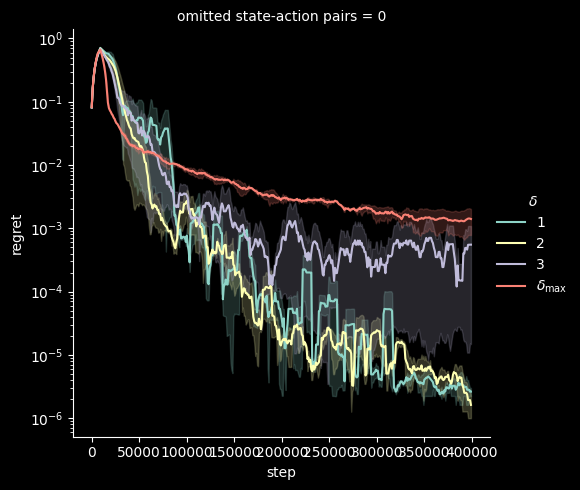

In [171]:
import seaborn as sns

g = sns.relplot(data=df, kind="line", x="step", y="regret", hue="$\delta$", col="omitted state-action pairs")
g.set(yscale="log")

In [149]:
df = orig.rename(columns={"_step": "step", "test-n/rmse": "test", "train-n/rmse": "train"})
df["delta"] = df["delta"].replace(100, r"$\delta_{\max}$")
df = df[df["step"] <= 400_000]

df = df.melt(id_vars=['step', "delta", "omitted state-action pairs"],  # or any other columns you want to keep unchanged
                    value_vars=['test', 'train'],
                    var_name='regime',
                    value_name='root mean-square error')

df =df.rename(columns={"delta": "$\delta$"})

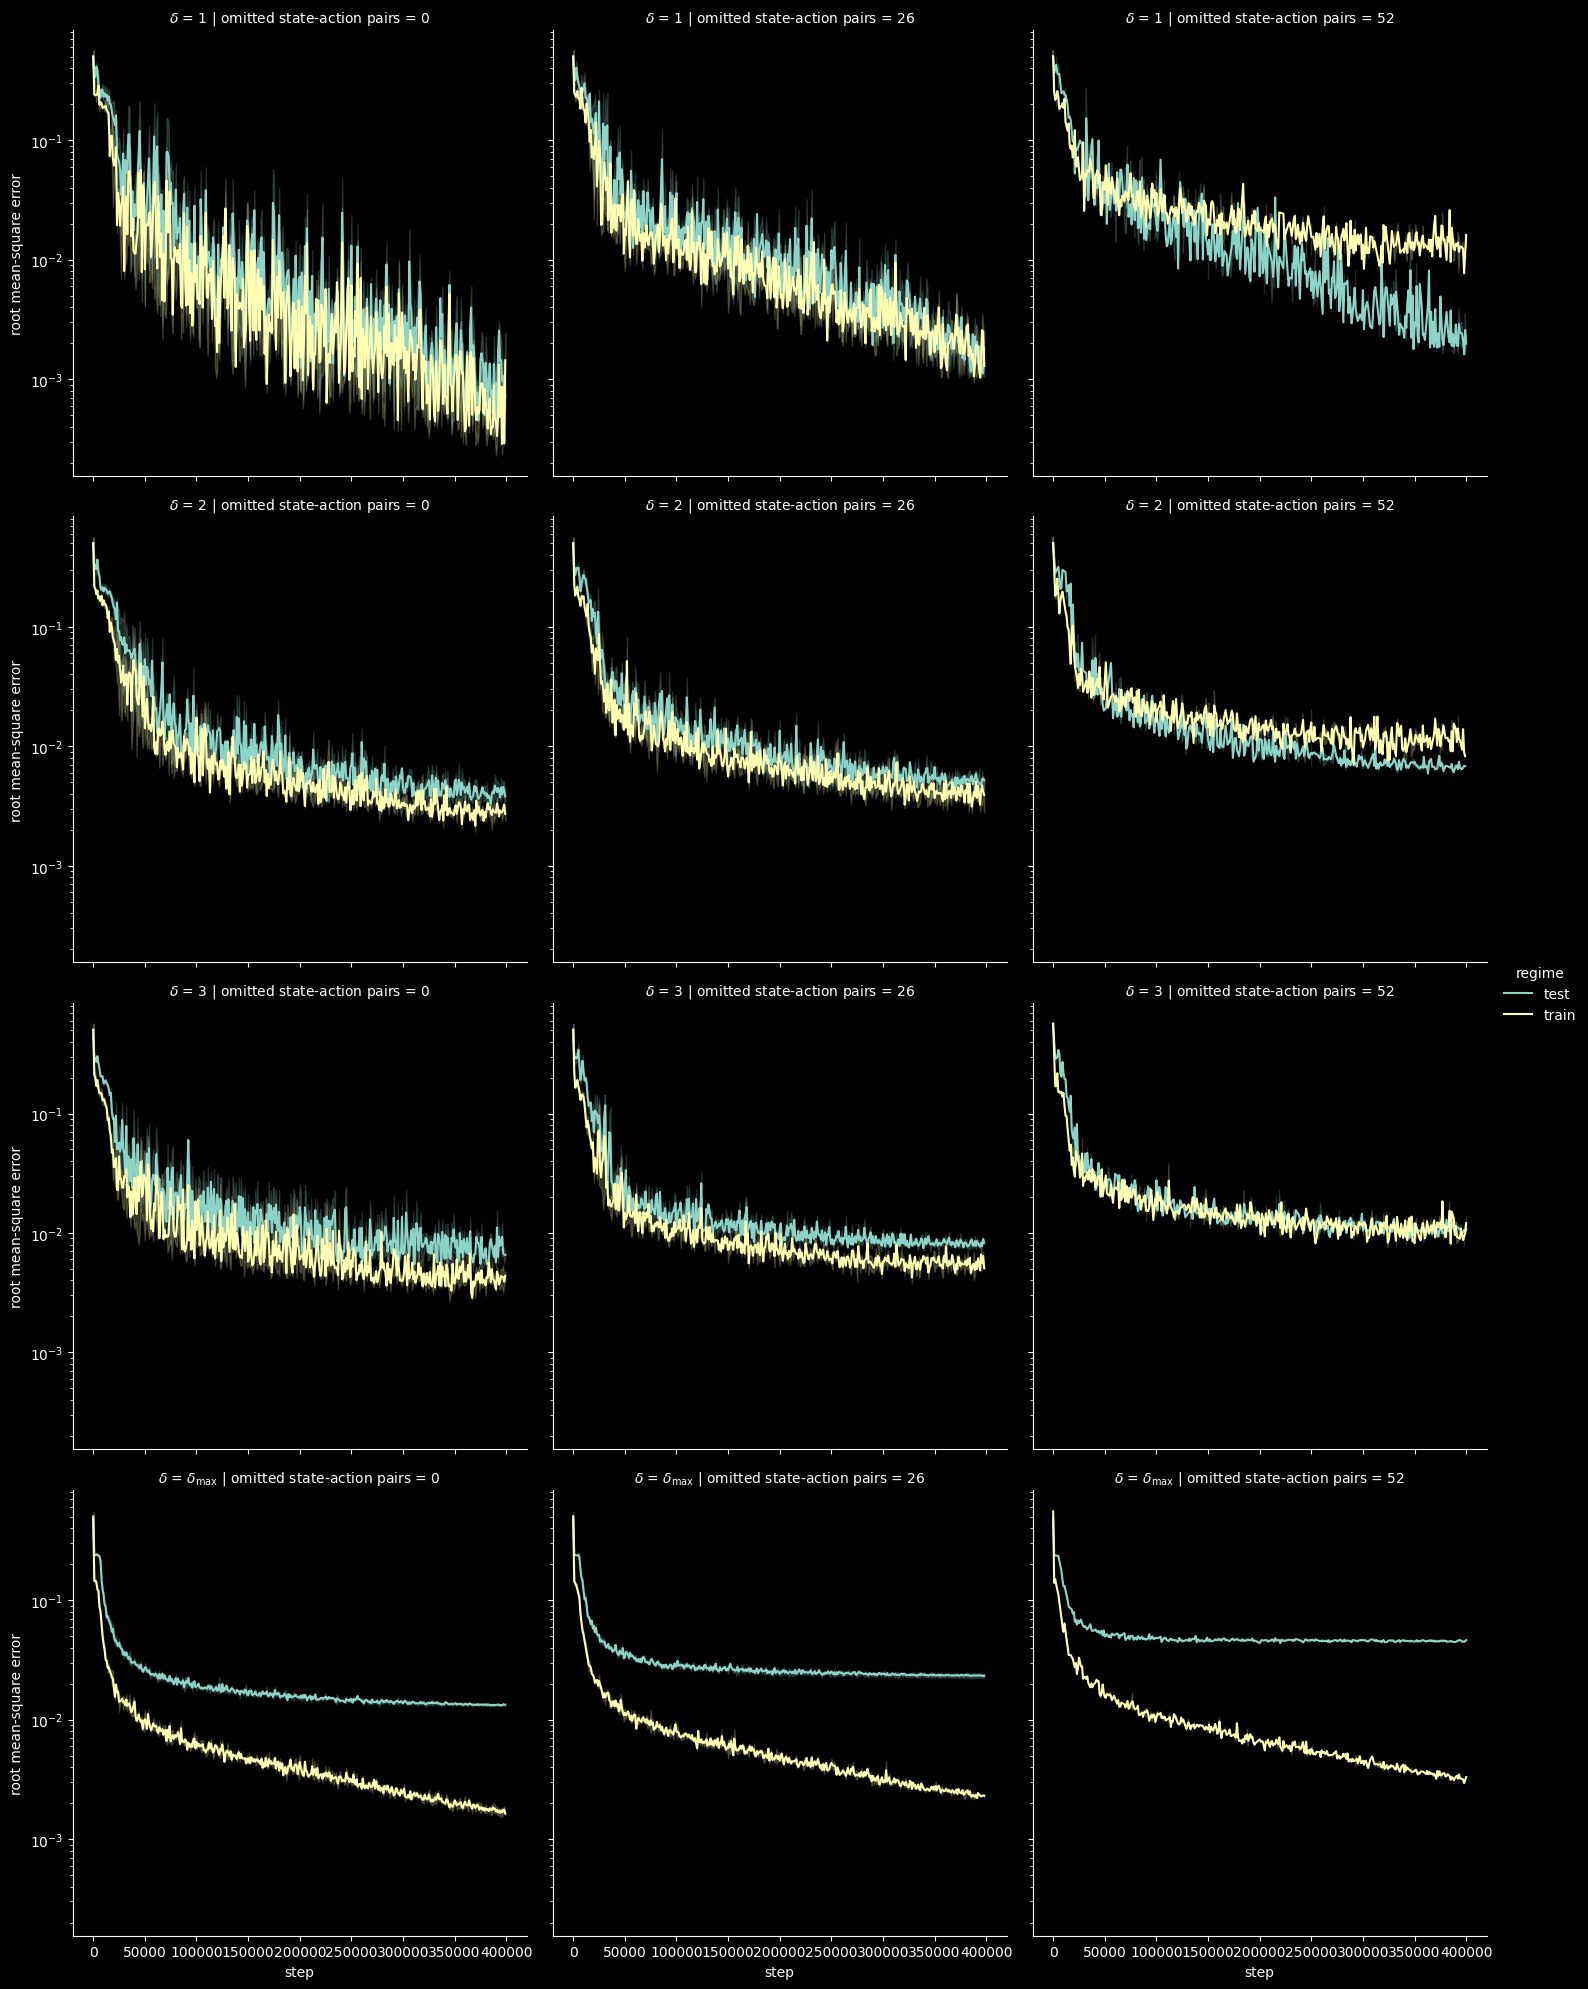

In [150]:
import seaborn as sns

g = sns.relplot(data=df, kind="line", x="step", y="root mean-square error", hue="regime", col="omitted state-action pairs", row="$\delta$")
g.set(yscale="log")